<center><h1>Implementing of ANFIS<br>in Python</h1></center>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
from fuzzy.datatype import DataTable
import fuzzy.input_space.memberfuncs as mfs
from fuzzy.input_space import discourse
from fuzzy.inference import rules, antecedent, consequent, aggregator, defuzzification
from fuzzy.system.inferece_system import InferenceSystem
from fuzzy.system import anfis
from fuzzy.utilies import report

import wang_mendel.trainer

<h3>Define Fuzzy Inference  System (FIS)<br>and their sets with CoA defuzzification</h3>

In [3]:
fuzzy_system = InferenceSystem(
    input_domain = discourse.Domain(
        discourse.Discourse(
            mfs.Trapezoidal(rhead=-5, rbase=-3.333),
            mfs.Triangular(-5, -3.333, -1.666),
            mfs.Triangular(-3.333, -1.666, 0),
            mfs.Triangular(-1.666, 0, 1.666),
            mfs.Triangular(0, 1.666, 3.333),
            mfs.Triangular(1.666, 3.333, 5),
            mfs.Trapezoidal(3.333, 5)
        ),
        discourse.Discourse(
            mfs.Trapezoidal(rhead=-5, rbase=-3.333),
            mfs.Triangular(-5, -3.333, -1.666),
            mfs.Triangular(-3.333, -1.666, 0),
            mfs.Triangular(-1.666, 0, 1.666),
            mfs.Triangular(0, 1.666, 3.333),
            mfs.Triangular(1.666, 3.333, 5),
            mfs.Trapezoidal(3.333, 5)
        )
    ),
    aggregator = aggregator.Max(),
    defuzzifier = defuzzification.CoA(
        discourse.Discourse(
            mfs.Trapezoidal(rhead=0, rbase=8.333),
            mfs.Triangular(0, 8.333, 16.666),
            mfs.Triangular(8.333, 16.666, 25),
            mfs.Triangular(16.666, 25, 33.333),
            mfs.Triangular(25, 33.333, 41.666),
            mfs.Triangular(33.333, 41.666, 50),
            mfs.Trapezoidal(41.666, 50)
        )
    )
)

<h3>Plotting sets of the FIS</h3>

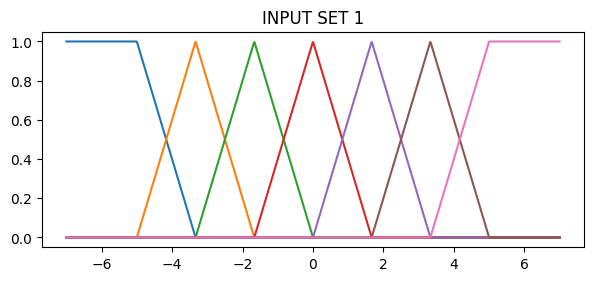

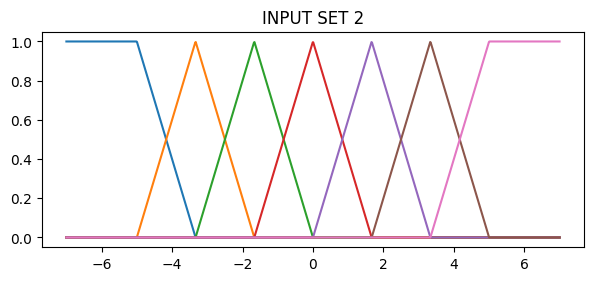

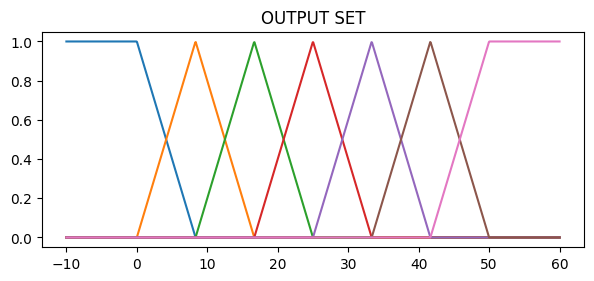

In [4]:
set_names = ['INPUT SET 1', 'INPUT SET 2', 'OUTPUT SET']
inputs=[
    np.linspace(-7, 7, 1000), 
    np.linspace(-7, 7, 1000), 
    np.linspace(-10, 60, 1000)
]
outputs=[
    np.array([dis(x) for x in input]).T 
    for dis, input in zip(fuzzy_system.input_domain, inputs)
]
outputs.append(np.array([
    fuzzy_system.defuzzifier.output_discourse(x) 
    for x in inputs[2]
]).T)

for inpt, output, name in zip(inputs, outputs, set_names):
    plt.figure(figsize=(7,2.8))
    for mfout in output:
        plt.plot(inpt, mfout)
    plt.title(name)

plt.show()

<h3>
    Train the defined FIS with<br>
    x<sub>1</sub><sup>2</sup>+x<sub>2</sub><sup>2</sup> function in range x<sub>1</sub>[-5, 5], x<sub>2</sub>[-5, 5]<br>
    with 1681 data
</h3>

In [5]:
input_range = np.linspace(-5, 5, 41).tolist()
train_data = DataTable()
train_data.inputs = [
    [x1, x2]
    for x1 in input_range
    for x2 in input_range
]
train_data.output = [
    x1 ** 2 + x2 ** 2
    for x1, x2 in train_data.inputs
]

trainer = wang_mendel.trainer.Trainer(
    input_domain = fuzzy_system.input_domain,
    output_discourse = fuzzy_system.defuzzifier.output_discourse,
    train_table = train_data,
    antecedent_type = antecedent.Product
)

fuzzy_system.rulebase = trainer.train()

<h3>Drawing Rule Base Table</h3>

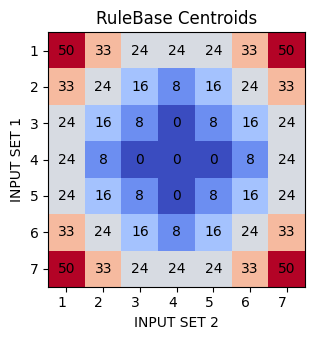

In [6]:
rows_Columns_text = [str(i) for i in range(1, 8)]
data = np.empty((7, 7), dtype = np.int32)
for rule in fuzzy_system.rulebase:
        data[
             rule[0].antecedent[0]
        ][
             rule[0].antecedent[1]
        ] = fuzzy_system.defuzzifier.output_discourse[
             rule[0].consequent()
        ].centroid
df = pd.DataFrame(
    data, 
    index = rows_Columns_text, 
    columns = rows_Columns_text
)

plt.figure(figsize = (3.25, 3.5))  
plt.imshow(df, cmap = 'coolwarm', aspect = 'auto') 

for i in range(df.shape[0]):  
    for j in range(df.shape[1]):  
        plt.text(j, i, str(df.iloc[i, j]), ha = 'center', va = 'center')

plt.xticks(ticks = np.arange(7), labels = rows_Columns_text, ha = 'right')
plt.yticks(ticks = np.arange(7), labels = rows_Columns_text)

plt.title("RuleBase Centroids")
plt.xlabel("INPUT SET 2")
plt.ylabel("INPUT SET 1")

plt.tight_layout()
plt.show()

<h3>Plotting fuzzy result of the FIS related to desired result</h3>

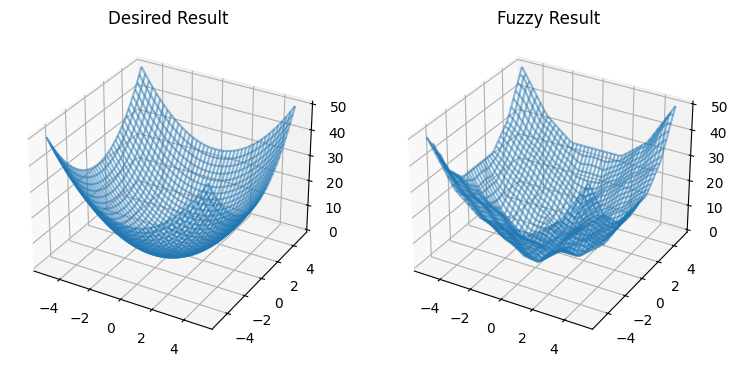

In [7]:
fig = plt.figure(figsize=(9, 10))

X1, X2 = np.meshgrid(input_range, input_range)

Z = X1 ** 2 + X2 ** 2
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_wireframe(X1, X2, Z, rstride=1, cstride=1, alpha=0.5)
ax.set_title('Desired Result')

ZP = np.array([[fuzzy_system([x1, x2]) for x1 in input_range] for x2 in input_range])
axp = fig.add_subplot(1, 2, 2, projection='3d')
axp.plot_wireframe(X1, X2, ZP, rstride=1, cstride=1, alpha=0.5)
axp.set_title('Fuzzy Result')

plt.show()

<h3>
    Calculating Mean Square Error of the FIS<br>
    for Train data and Test data with 169 random data over 100 iteration
</h3>

In [8]:
fis_mse = report.MeanSquareError(fuzzy_system)
fis_mse.test_tables = train_data
mse_mean, mse_std = fis_mse()
print(f"Mean Square Error for train data: {mse_mean / 2:.4f}")

test_inputs = [
     np.random.uniform(-5, 5, size=(169, 2)).tolist()
     for _ in range(100)
]

test_data = [
     DataTable(
          inputs= inpts,
          output= [
               x1 ** 2 + x2 ** 2
               for x1, x2 in inpts
          ]
     )
     for inpts in test_inputs
]

fis_mse.test_tables = test_data
mse_mean, mse_std = fis_mse()
print(f"Mean Square Error for test data: {mse_mean / 2:.4f} ± {mse_std / 2:.3f}")

Mean Square Error for train data: 1.8978
Mean Square Error for test data: 1.9108 ± 0.200


<h3>Configuring ANFIS</h3>

In [9]:
anfis_sys = anfis.ANFIS(
     input_domain= fuzzy_system.input_domain,
     antecedents= [
          rule[0].antecedent 
          for rule in fuzzy_system.rulebase
     ],
     consequents= [
          consequent.Sugeno(
               fuzzy_system.defuzzifier.output_discourse[
                    rule[0].consequent()
                ].centroid
          )
          for rule in fuzzy_system.rulebase
     ]
)

<h3>Training ANFIS</h3>

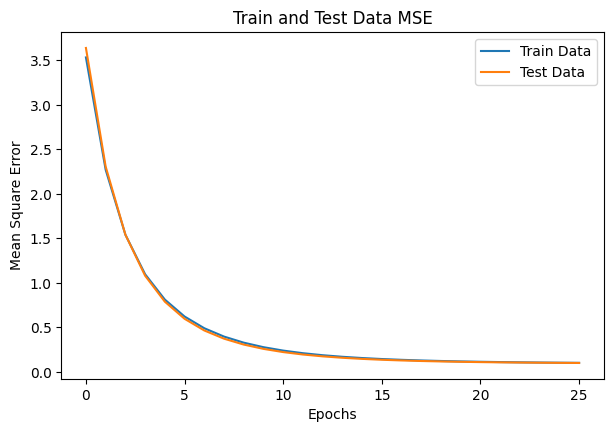

In [10]:
train_mses, test_mses = anfis.train(
     anfis_system= anfis_sys,
     eta= 0.01,
     epochs_no= 25,
     train_table= train_data,
     test_tables= test_data[:10]
)

plt.figure(figsize=(7, 4.5))

plt.plot(train_mses, label='Train Data')
plt.plot(test_mses, label='Test Data')

plt.title('Train and Test Data MSE')
plt.xlabel("Epochs")
plt.ylabel("Mean Square Error")

plt.legend(loc='upper right')
plt.show()

<h3>Drawing Consequences Table</h3>

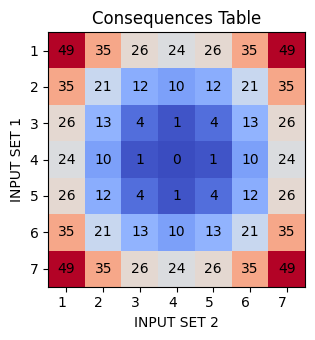

In [11]:
data = np.empty((7, 7), dtype = np.int32)
for antc, cons in zip(anfis_sys.antecedents, anfis_sys.consequents):
        data[
             antc[0]
        ][
             antc[1]
        ] = cons()
df = pd.DataFrame(
    data, 
    index = rows_Columns_text, 
    columns = rows_Columns_text
)

plt.figure(figsize = (3.25, 3.5))  
plt.imshow(df, cmap = 'coolwarm', aspect = 'auto') 

for i in range(df.shape[0]):  
    for j in range(df.shape[1]):  
        plt.text(j, i, str(df.iloc[i, j]), ha = 'center', va = 'center')

plt.xticks(ticks = np.arange(7), labels = rows_Columns_text, ha = 'right')
plt.yticks(ticks = np.arange(7), labels = rows_Columns_text)

plt.title("Consequences Table")
plt.xlabel("INPUT SET 2")
plt.ylabel("INPUT SET 1")

plt.tight_layout()
plt.show()

<h3>Plotting fuzzy result of the ANFIS related to desired result</h3>

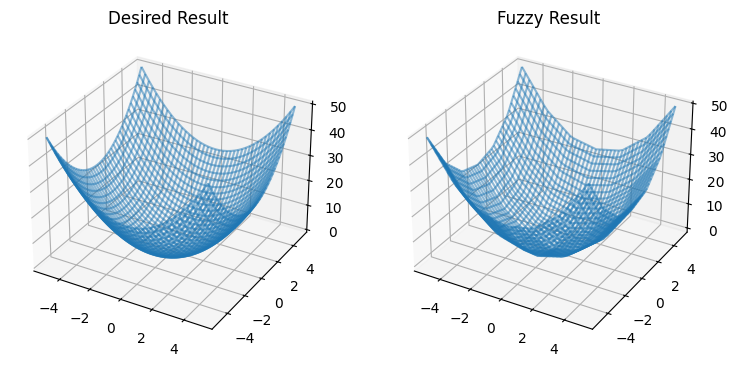

In [12]:
fig = plt.figure(figsize=(9, 10))

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_wireframe(X1, X2, Z, rstride=1, cstride=1, alpha=0.5)
ax.set_title('Desired Result')

ZP = np.array([[anfis_sys([x1, x2]) for x1 in input_range] for x2 in input_range])
axp = fig.add_subplot(1, 2, 2, projection='3d')
axp.plot_wireframe(X1, X2, ZP, rstride=1, cstride=1, alpha=0.5)
axp.set_title('Fuzzy Result')

plt.show()

<h3>
    Calculating Mean Square Error of the ANFIS<br>
    for Train data and Test data with 169 random data over 100 iteration
</h3>

In [13]:
anfis_mse = report.MeanSquareError(anfis_sys)
anfis_mse.test_tables = train_data
mse_mean, mse_std = anfis_mse()
print(f"Mean Square Error for train data: {mse_mean / 2:.4f}")

anfis_mse.test_tables = test_data
mse_mean, mse_std = anfis_mse()
print(f"Mean Square Error for test data: {mse_mean / 2:.4f} ± {mse_std / 2:.3f}")

Mean Square Error for train data: 0.0514
Mean Square Error for test data: 0.0485 ± 0.004


<hr>
<b>
    Habib Ghanizadeh<br>
    Student No: 403066457<br>
    mail: <a href="mailto:h.a.ghanizadeh@gmail.com">h.a.ghanizadeh@gmail.com</a>
</b>